In [14]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
%matplotlib inline

import json
import numpy as np

from collections import Counter
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN

from utils import *
from FedRank import FedRank

In [15]:
# develop mode
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Moscow coordinates
MOW = [55.75222, 37.61556]

r = 0.02
r2 = r**2

In [17]:
# load mcc codes
mcc_codes = pd.read_csv('./data/mcc_codes.csv', index_col='mcc')

In [18]:
# load, clean and group train data
train_df = clean_df('./data/train_set.csv')
train_gr = train_df.groupby('customer_id')
train_df.head()

C:\Anaconda3\work\raiffazen\env\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (1,11) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,amount,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon
0,2.884034,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,11606fde0c814ce78e0d726e39a0a5ee,2017-07-15,59.847,30.177
1,2.775633,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,e9647a5e1eacfb06713b6af755ccc595,2017-10-27,59.847,30.177
2,3.708368,St Petersburg,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5992,"PR.MARSHALA ZHUKOVA,31St Petersburg190000 7...",59.858198,30.229024,df06c1fcd3718a514535ae822785f716,2017-10-03,59.847,30.177
3,2.787498,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,6c5e5793ebc984fb72875feffff62854,2017-09-09,59.847,30.177
4,2.892510,ST PETERSBURG,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5261,,59.844072,30.179153,0576445d74e374c92c0902e612fca356,2017-07-06,59.847,30.177


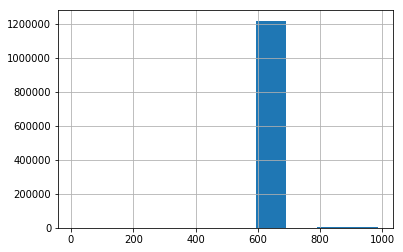

In [186]:
train_df.currency.hist()

In [188]:
train_df.currency.unique()

array([643., 978.,  nan, 784., 360., 764., 980., 981., 975., 840., 191.,
       376., 752., 344., 949., 933., 156., 417., 398., 203., 400., 504.,
        51., 826., 356., 484., 352., 944., 788., 498., 818., 348., 702.,
        36., 704., 214., 941., 554., 682., 985., 124., 946., 388., 144.,
       458., 710., 756., 208., 392., 860., 972., 404., 604., 578.,   8.,
       807., 634., 608., 834., 977., 496.])

In [187]:
# clean dataset and remove all non-rubles transactions and select derearable MMC only

In [19]:
test_df = clean_df('./data/test_set.csv')
test_gr = test_df.groupby('customer_id')

C:\Anaconda3\work\raiffazen\env\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (1,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [ ]:
mcc_code = 5411

In [20]:
best_dbscan_params = {'eps': 0.036, 'min_samples': 2}

In [182]:
def get_dbscan_clust(df, dbscan_params):
    
    score = 0
    res = pd.DataFrame(columns=['clust_label'])
    for user_id, user_data in df:
        test_set = user_data.query('mcc == @mcc_code')
        position = test_set.loc[:,['pos_address_lat', 'pos_address_lon']].dropna()      
        if len(position) >0:
            
            dbs = DBSCAN(**dbscan_params)
            dbs.fit(position)
            res = res.append(pd.DataFrame(dbs.labels_, index=position.index, columns= ['clust_label']))
        
    return res

In [184]:
clusters = get_dbscan_clust(train_gr, best_dbscan_params)

In [23]:
train_df = train_df.merge(clusters, left_index=True, right_index=True, how='left')
train_df.clust_label.fillna(-2, inplace=True)
t_gr = train_df.groupby(['customer_id','clust_label'])

In [174]:
mcc_list = [
    5411, # supermarkets
    6011  # ATM
]

In [181]:
train_df[train_df.mcc.isin(mcc_list)]

,amount,city,country,currency,customer_id,home_add_lat,home_add_lon,mcc,pos_address,pos_address_lat,pos_address_lon,terminal_id,transaction_date,work_add_lat,work_add_lon,clust_label
10,3.109393,SANKT-PETERBU,RUS,643.0,0dc0137d280a2a82d2dc89282450ff1b,59.851,30.232,5411,2 PARTIZANA GERMANA STRSANKT-PETERBU190000 ...,59.844072,30.179153,db6ce42a72e5fa3ec91dc2c883e265e3,2017-10-03,59.847,30.177,-1
20,2.849170,NOVOSIBIRSK,RUS,643.0,0e4c72f1c28452fe3bab0283381b8afd,54.993,82.846,5411,"2,TROLLEYNAYANOVOSIBIRSK630108 RUSRUS",54.970228,82.861248,963873075eda3b9ce1ff4b75717bed47,2017-07-03,NaN,NaN,0
22,2.881898,NOVOSIBIRSK,RUS,643.0,0e4c72f1c28452fe3bab0283381b8afd,54.993,82.846,5411,3 KARLA MARKSA SQNOVOSIBIRSK630048 RUSRUS,54.983245,82.891522,868ca19864b882a371e9e148e46f64dd,2017-07-19,NaN,NaN,0
24,2.972522,NOVOSIBIRSK,RUS,643.0,0e4c72f1c28452fe3bab0283381b8afd,54.993,82.846,5411,3 KARLA MARKSA SQNOVOSIBIRSK630048 RUSRUS,54.983245,82.891522,7118b59ee4403518ceedc6279a56f4e5,2017-08-10,NaN,NaN,0
29,2.262548,NOVOSIBIRSK,RUS,643.0,0e4c72f1c28452fe3bab0283381b8afd,54.993,82.846,5411,UL SHIROKAYA 1NOVOSIBIRSK630108 RUSRUS,54.994059,82.868267,39a3e15c76815ade49c666ad50227740,2017-05-12,NaN,NaN,0
33,2.850720,NOVOSIBIRSK,RUS,643.0,0e4c72f1c28452fe3bab0283381b8afd,54.993,82.846,5411,3 KARLA MARKSA SQNOVOSIBIRSK630048 RUSRUS,54.983245,82.891522,c88255ca0706d0ba02c6dfdeb10a0a9b,2017-07-15,NaN,NaN,0
39,2.199821,NOVOSIBIRSK,RUS,643.0,0e4c72f1c28452fe3bab0283381b8afd,54.993,82.846,5411,UL VATUTINA 9NOVOSIBIRSK630078 RUSRUS,54.989234,82.886256,3982bc9e223430364c7a9cedc530abf7,2017-05-13,NaN,NaN,0
49,2.426980,NOVOSIBIRSK,RUS,643.0,0e4c72f1c28452fe3bab0283381b8afd,54.993,82.846,5411,3 KARLA MARKSA SQNOVOSIBIRSK630048 RUSRUS,54.983245,82.891522,e75745320e99373c013a355a84b92e99,2017-06-10,NaN,NaN,0
59,2.686273,MOSCOW,RUS,643.0,13d194bdf7adf721eeec5c438879da08,56.734,37.166,5411,99 LENINSKIY PR-TMOSCOW119421 RUSRUS,55.668335,37.518274,8f78ed2500723a8aa0610af144675170,2017-05-23,NaN,NaN,-1
62,2.827581,MOSCOW,RUS,643.0,19b1319d29fd9d85ce9bfee83e42d51f,55.890,37.561,5411,"Leningradskoe shosse, 71gMOSCOW125445 RUSRUS",55.875753,37.445097,41f26348ed58e8fea749f80870f053f7,2017-05-26,NaN,NaN,0


In [170]:
train_df.mcc

0          5261
1          5261
2          5992
3          5261
4          5261
5          5261
6          5261
7          5261
8          5261
9          5261
10         5411
11         5814
12         5812
13         5814
14         5813
15         5499
16         5814
17         5912
18         4111
19         4111
20         5411
21         5814
22         5411
23         5499
24         5411
25         5499
26         5814
27         5691
28         5499
29         5411
           ... 
1224704    6011
1224705    6011
1224706    6011
1224707    6011
1224708    6011
1224709    6011
1224710    6011
1224711    6011
1224712    6011
1224713    6011
1224714    6011
1224715    6011
1224716    6011
1224717    6011
1224718    6011
1224719    6011
1224720    6011
1224721    6011
1224722    6011
1224723    6011
1224724    6011
1224725    6011
1224726    6011
1224727    6011
1224728    6011
1224729    6011
1224730    6011
1224731    6011
1224732    6011
1224733    6011
Name: mcc, Length: 12247

In [168]:
t_gr.mcc.aggregate('value_counts', **{'normalize':True})

customer_id                       clust_label  mcc 
0001f322716470bf9bfc1708f06f00fc  -2           6011    0.819277
                                               5541    0.084337
                                               5999    0.048193
                                               5211    0.012048
                                               5499    0.012048
                                               5621    0.012048
                                               5912    0.012048
                                   0           5411    1.000000
                                   1           5411    1.000000
                                   2           5411    1.000000
0007297d86e14bd68bd87b1dbdefe302  -2           6011    0.379121
                                               5814    0.307692
                                               5912    0.060440
                                               5812    0.043956
                                               5999 

In [166]:
### Create features with relative contributions of each MCC code for each cluster of each customer
k = t_gr.mcc.aggregate('value_counts', **{'normalize':True}).unstack(level=-1).fillna(0)
k.head()

mcc                                           50    146   160   165   168   \
customer_id                      clust_label                                 
0001f322716470bf9bfc1708f06f00fc -2            0.0   0.0   0.0   0.0   0.0   
                                  0            0.0   0.0   0.0   0.0   0.0   
                                  1            0.0   0.0   0.0   0.0   0.0   
                                  2            0.0   0.0   0.0   0.0   0.0   
0007297d86e14bd68bd87b1dbdefe302 -2            0.0   0.0   0.0   0.0   0.0   

mcc                                           169   176   183   186   194   \
customer_id                      clust_label                                 
0001f322716470bf9bfc1708f06f00fc -2            0.0   0.0   0.0   0.0   0.0   
                                  0            0.0   0.0   0.0   0.0   0.0   
                                  1            0.0   0.0   0.0   0.0   0.0   
                                  2            0.0   0.0   0.0   0.0   0.0   
0007297d86e14bd68bd87b1dbdefe302 -2            0.0   0.0   0.0   0.0   0.0   

mcc                                           ...   8398  8661  8699  8911  \
customer_id                      clust_label  ...                            
0001f322716470bf9bfc1708f06f00fc -2           ...    0.0   0.0   0.0   0.0   
                                  0           ...    0.0   0.0   0.0   0.0   
                                  1           ...    0.0   0.0   0.0   0.0   
                                  2           ...    0.0   0.0   0.0   0.0   
0007297d86e14bd68bd87b1dbdefe302 -2           ...    0.0   0.0   0.0   0.0   

mcc                                               8999  9211  9222  9311  \
customer_id                      clust_label                               
0001f322716470bf9bfc1708f06f00fc -2           0.000000   0.0   0.0   0.0   
                                  0           0.000000   0.0   0.0   0.0   
                                  1           0.000000   0.0   0.0   0.0   
                                  2           0.000000   0.0   0.0   0.0   
0007297d86e14bd68bd87b1dbdefe302 -2           0.010989   0.0   0.0   0.0   

mcc                                           9399  9402  
customer_id                      clust_label              
0001f322716470bf9bfc1708f06f00fc -2            0.0   0.0  
                                  0            0.0   0.0  
                                  1            0.0   0.0  
                                  2            0.0   0.0  
0007297d86e14bd68bd87b1dbdefe302 -2            0.0   0.0  

[5 rows x 284 columns]

In [155]:
k2 = k.pivot_table(columns='mcc', values='mcc_count')

In [165]:
k.loc[:,5411]

customer_id                       clust_label
0001f322716470bf9bfc1708f06f00fc  -2             0.0
                                   0             1.0
                                   1             1.0
                                   2             1.0
0007297d86e14bd68bd87b1dbdefe302  -2             0.0
                                   0             1.0
                                   1             1.0
                                   2             1.0
                                   3             1.0
000b709c6c6fb1e8efcfd95e57c2a9de  -2             0.0
                                  -1             1.0
                                   0             1.0
                                   1             1.0
0027a7618d97cc9fbda55fac457eaeb7  -2             0.0
                                  -1             1.0
                                   0             1.0
                                   1             1.0
                                   2             1.0


In [120]:
p = k.to_frame().loc['0007297d86e14bd68bd87b1dbdefe302'].copy().rename(columns = {'mcc':'mcc_count'}).reset_index(level = 1)
p.head()

,mcc,mcc_count
clust_label,,
-2,6011,69
-2,5814,56
-2,5912,11
-2,5812,8
-2,5999,7


In [125]:
p2 = p.pivot(columns='mcc', values='mcc_count').fillna(0)
p2.head()

In [39]:
agg_dict = {
    'pos_address_lat':np.mean,
    'pos_address_lon': np.mean,
    'amount': [np.mean, np.max, np.min, 'count', 'std']
}

agg_dict.update({'home_add_lat': np.mean, 'home_add_lon': np.mean, 'work_add_lat': np.mean, 'work_add_lon': np.mean,})

c = t_gr.aggregate(agg_dict)
newidx = []
for (n1,n2) in c.columns.ravel():
    newidx.append("%s_%s" % (n1,n2))
c.columns=newidx
c.head(10)

pos_address_lat_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      17.785491   
                                  0                      56.251347   
                                  1                      44.744977   
                                  2                      44.711199   
0007297d86e14bd68bd87b1dbdefe302 -2                      53.649054   
                                  0                      55.800632   
                                  1                      55.822604   
                                  2                      55.670268   
                                  3                      55.747618   
000b709c6c6fb1e8efcfd95e57c2a9de -2                      53.443488   

                                              pos_address_lon_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      15.020104   
                                  0                      43.446254   
                                  1                      37.725649   
                                  2                      37.846624   
0007297d86e14bd68bd87b1dbdefe302 -2                      35.916029   
                                  0                      37.400692   
                                  1                      37.524894   
                                  2                      37.481117   
                                  3                      37.537587   
000b709c6c6fb1e8efcfd95e57c2a9de -2                      73.031566   

                                              amount_mean  amount_amax  \
customer_id                      clust_label                             
0001f322716470bf9bfc1708f06f00fc -2              3.343322     4.614833   
                                  0              2.553616     2.973381   
                                  1              3.016776     3.460175   
                                  2              2.203973     2.394246   
0007297d86e14bd68bd87b1dbdefe302 -2              2.859040     4.696914   
                                  0              2.834341     3.596210   
                                  1              2.820427     3.401110   
                                  2              1.830931     2.290534   
                                  3              2.425873     3.211002   
000b709c6c6fb1e8efcfd95e57c2a9de -2              2.949456     4.319009   

                                              amount_amin  amount_count  \
customer_id                      clust_label                              
0001f322716470bf9bfc1708f06f00fc -2              1.982628            83   
                                  0              2.347082             7   
                                  1              2.407830             3   
                                  2              1.949756             7   
0007297d86e14bd68bd87b1dbdefe302 -2              0.706783           182   
                                  0              0.816582            40   
                                  1              2.359619             3   
                                  2              1.483227             3   
                                  3              1.936728            19   
000b709c6c6fb1e8efcfd95e57c2a9de -2              1.730401            32   

                                              amount_std  home_add_lat_mean  \
customer_id                      clust_label                                  
0001f322716470bf9bfc1708f06f00fc -2             0.761167             44.708   
                                  0             0.233241             44.708   
                                  1             0.545355             44.708   
                                  2             0.160099             44.708   
0007297d86e14bd68bd87b1dbdefe302 -2             0.733852             55.799   
                     

In [69]:
p = c
p.head()

pos_address_lat_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      17.785491   
                                  0                      56.251347   
                                  1                      44.744977   
                                  2                      44.711199   
0007297d86e14bd68bd87b1dbdefe302 -2                      53.649054   

                                              pos_address_lon_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      15.020104   
                                  0                      43.446254   
                                  1                      37.725649   
                                  2                      37.846624   
0007297d86e14bd68bd87b1dbdefe302 -2                      35.916029   

                                              amount_mean  amount_amax  \
customer_id                      clust_label                             
0001f322716470bf9bfc1708f06f00fc -2              3.343322     4.614833   
                                  0              2.553616     2.973381   
                                  1              3.016776     3.460175   
                                  2              2.203973     2.394246   
0007297d86e14bd68bd87b1dbdefe302 -2              2.859040     4.696914   

                                              amount_amin  amount_count  \
customer_id                      clust_label                              
0001f322716470bf9bfc1708f06f00fc -2              1.982628            83   
                                  0              2.347082             7   
                                  1              2.407830             3   
                                  2              1.949756             7   
0007297d86e14bd68bd87b1dbdefe302 -2              0.706783           182   

                                              amount_std  home_add_lat_mean  \
customer_id                      clust_label                                  
0001f322716470bf9bfc1708f06f00fc -2             0.761167             44.708   
                                  0             0.233241             44.708   
                                  1             0.545355             44.708   
                                  2             0.160099             44.708   
0007297d86e14bd68bd87b1dbdefe302 -2             0.733852             55.799   

                                              home_add_lon_mean  \
customer_id                      clust_label                      
0001f322716470bf9bfc1708f06f00fc -2                      37.775   
                                  0                      37.775   
                                  1                      37.775   
                                  2                      37.775   
0007297d86e14bd68bd87b1dbdefe302 -2                      37.388   

                                              work_add_lat_mean  \
customer_id                      clust_label                      
0001f322716470bf9bfc1708f06f00fc -2                      44.735   
                                  0                      44.735   
                                  1                      44.735   
                                  2                      44.735   
0007297d86e14bd68bd87b1dbdefe302 -2                         NaN   

                                              work_add_lon_mean  
customer_id                      clust_label                     
0001f322716470bf9bfc1708f06f00fc -2                      37.798  
                                  0                      37.798  
                                  1                      37.798  
                                  2                      37.798  
0007297d86e14bd68bd87b1dbdefe302 -2                         NaN

In [70]:
dist = get_target_distances(p).fillna(999)
dist.head(10)

dist_home    dist_work
customer_id                      clust_label                          
0001f322716470bf9bfc1708f06f00fc -2           1242.606770  1245.108569
                                  0            165.411979   164.529019
                                  1              0.003803     0.005334
                                  2              0.005140     0.002931
0007297d86e14bd68bd87b1dbdefe302 -2              6.788967   999.000000
                                  0              0.000164   999.000000
                                  1              0.019297   999.000000
                                  2              0.025243   999.000000
                                  3              0.025016   999.000000
000b709c6c6fb1e8efcfd95e57c2a9de -2             99.080842    99.361746

In [71]:
p = p.merge(dist, left_index=True, right_index=True)
p.head()

pos_address_lat_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      17.785491   
                                  0                      56.251347   
                                  1                      44.744977   
                                  2                      44.711199   
0007297d86e14bd68bd87b1dbdefe302 -2                      53.649054   

                                              pos_address_lon_mean  \
customer_id                      clust_label                         
0001f322716470bf9bfc1708f06f00fc -2                      15.020104   
                                  0                      43.446254   
                                  1                      37.725649   
                                  2                      37.846624   
0007297d86e14bd68bd87b1dbdefe302 -2                      35.916029   

                                              amount_mean  amount_amax  \
customer_id                      clust_label                             
0001f322716470bf9bfc1708f06f00fc -2              3.343322     4.614833   
                                  0              2.553616     2.973381   
                                  1              3.016776     3.460175   
                                  2              2.203973     2.394246   
0007297d86e14bd68bd87b1dbdefe302 -2              2.859040     4.696914   

                                              amount_amin  amount_count  \
customer_id                      clust_label                              
0001f322716470bf9bfc1708f06f00fc -2              1.982628            83   
                                  0              2.347082             7   
                                  1              2.407830             3   
                                  2              1.949756             7   
0007297d86e14bd68bd87b1dbdefe302 -2              0.706783           182   

                                              amount_std  home_add_lat_mean  \
customer_id                      clust_label                                  
0001f322716470bf9bfc1708f06f00fc -2             0.761167             44.708   
                                  0             0.233241             44.708   
                                  1             0.545355             44.708   
                                  2             0.160099             44.708   
0007297d86e14bd68bd87b1dbdefe302 -2             0.733852             55.799   

                                              home_add_lon_mean  \
customer_id                      clust_label                      
0001f322716470bf9bfc1708f06f00fc -2                      37.775   
                                  0                      37.775   
                                  1                      37.775   
                                  2                      37.775   
0007297d86e14bd68bd87b1dbdefe302 -2                      37.388   

                                              work_add_lat_mean  \
customer_id                      clust_label                      
0001f322716470bf9bfc1708f06f00fc -2                      44.735   
                                  0                      44.735   
                                  1                      44.735   
                                  2                      44.735   
0007297d86e14bd68bd87b1dbdefe302 -2                         NaN   

                                              work_add_lon_mean    dist_home  \
customer_id                      clust_label                                   
0001f322716470bf9bfc1708f06f00fc -2                      37.798  1242.606770   
                                  0                      37.798   165.411979   
                                  1                      37.798     0.003803   
                                  2                      37.798     0.005140   
0007297d86e14bd68bd87b1dbdefe302 -2          

In [72]:
p = p.reset_index().query('clust_label > -1')

In [73]:
ranker = FedRank()

In [80]:
features = ['dist_home', 'dist_work']
y = ranker.transform(p, features)
y.head(10)

,dist_home_rank,dist_work_rank
1,3,3
2,1,2
3,2,1
5,1,2
6,2,2
7,4,2
8,3,2
11,2,2
12,1,1
15,3,2


In [82]:
p.head()

,customer_id,clust_label,pos_address_lat_mean,pos_address_lon_mean,amount_mean,amount_amax,amount_amin,amount_count,amount_std,home_add_lat_mean,home_add_lon_mean,work_add_lat_mean,work_add_lon_mean,dist_home,dist_work
1,0001f322716470bf9bfc1708f06f00fc,0,56.251347,43.446254,2.553616,2.973381,2.347082,7,0.233241,44.708,37.775,44.735,37.798,165.411979,164.529019
2,0001f322716470bf9bfc1708f06f00fc,1,44.744977,37.725649,3.016776,3.460175,2.407830,3,0.545355,44.708,37.775,44.735,37.798,0.003803,0.005334
3,0001f322716470bf9bfc1708f06f00fc,2,44.711199,37.846624,2.203973,2.394246,1.949756,7,0.160099,44.708,37.775,44.735,37.798,0.005140,0.002931
5,0007297d86e14bd68bd87b1dbdefe302,0,55.800632,37.400692,2.834341,3.596210,0.816582,40,0.560534,55.799,37.388,NaN,NaN,0.000164,999.000000
6,0007297d86e14bd68bd87b1dbdefe302,1,55.822604,37.524894,2.820427,3.401110,2.359619,3,0.530993,55.799,37.388,NaN,NaN,0.019297,999.000000


In [83]:
features = ['amount_mean', 'amount_count', 'amount_std']
X = ranker.transform(p, features)
X.head()

,amount_mean_rank,amount_count_rank,amount_std_rank
1,2,2,2
2,3,1,3
3,1,2,1
5,4,4,4
6,3,1,3


In [84]:
y.head()

,dist_home_rank,dist_work_rank
1,3,3
2,1,2
3,2,1
5,1,2
6,2,2


### Обучение и тестирование

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Подбор гиперпараметров для DBSCAN

In [ ]:
eps_list = np.logspace(-2, -1, 5)
min_samples_list = [5, 10, 15, 20, 25, 30]

res = {}

for min_samples in min_samples_list:
    for eps in eps_list: 
        res_df = get_dbscan_score(customer_gr, {'leaf_size':5, 'eps': eps, 'min_samples': min_samples})
        score = res_df.query('dist < @r2').shape[0]
        print(f'{eps}, {min_samples}, {score}')
        res.update({(eps, min_samples,):score})

In [ ]:
eps_list = np.logspace(-3, -1, 10)
min_samples_list = [1, 2, 3, 4, 5]

res = {}

for min_samples in min_samples_list:
    for eps in eps_list: 
        res_df = get_dbscan_score(customer_gr, {'leaf_size':5, 'eps': eps, 'min_samples': min_samples})
        score = res_df.query('dist < @r2').shape[0]
        print(f'{eps}, {min_samples}, {score}')
        res.update({(eps, min_samples,):score})

Наилучшие результаты получены при eps = 0.036, min_samples = 1

In [ ]:
train_pr = get_dbscan_score(train_gr, best_dbscan_params)

In [ ]:
train_pr.head()

In [ ]:
train_pr.clust_amount.hist(bins = 100)
plt.xlim([0, 20])

Теперь оценим реальный скор, который я могу выбить

In [ ]:
0.5* train_pr.query('dist <= @r2').shape[0]/train_pr.shape[0]

На борде скор 0.206375

In [ ]:
test_pr = get_dbscan_score(test_gr, best_dbscan_params, calc_dist= False)
test_pr.head()

In [ ]:
submit = test_pr.loc[:,['home_post_lat', 'home_post_lon', 'best_post_lat',  'best_post_lon']]
submit.head()

In [ ]:
submit.columns = ['best_post_lat', 'best_post_lon',  'home_post_lat', 'home_post_lon', 'dist', 'clust_size']

In [ ]:
submit.to_csv('1.csv')